1.环境准备

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# 设置随机种子
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

使用设备: cpu


2. 数据加载与预处理

In [10]:
def load_and_preprocess_data(file_path):
    # 加载数据
    df = pd.read_csv(file_path, parse_dates=['date'])
    print("数据加载完成，开始特征工程...")
    
    # 基础特征工程
    # 价格变化特征
    df['returns'] = df['price'].pct_change()
    df['returns_2'] = df['price'].pct_change(2)
    df['returns_5'] = df['price'].pct_change(5)
    
    # 波动率特征
    for window in [3, 5, 10, 20]:
        df[f'volatility_{window}d'] = df['returns'].rolling(window).std()
    
    # 移动平均特征
    for window in [5, 10, 20]:
        df[f'ma_{window}'] = df['price'].rolling(window).mean()
        df[f'ma_ratio_{window}'] = df['price'] / df[f'ma_{window}']
    
    # RSI指标
    def calculate_rsi(prices, period=14):
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))
    
    df['rsi_14'] = calculate_rsi(df['price'])
    
    # MACD指标
    exp1 = df['price'].ewm(span=12, adjust=False).mean()
    exp2 = df['price'].ewm(span=26, adjust=False).mean()
    df['macd'] = exp1 - exp2
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    df['macd_hist'] = df['macd'] - df['macd_signal']
    
    # 情感特征
    df['sentiment_ma_3'] = df['sentiment_score'].rolling(3).mean()
    df['sentiment_ma_7'] = df['sentiment_score'].rolling(7).mean()
    
    # 目标变量：未来3天的价格变化率
    df['target'] = df['price'].pct_change(3).shift(-3)
    
    # 删除缺失值
    df = df.dropna()
    
    print("特征工程完成，开始特征选择...")
    
    # 特征选择
    features = [
        'returns', 'returns_2', 'returns_5',
        'volatility_3d', 'volatility_5d', 'volatility_10d', 'volatility_20d',
        'ma_ratio_5', 'ma_ratio_10', 'ma_ratio_20',
        'rsi_14', 'macd', 'macd_hist',
        'sentiment_score', 'sentiment_ma_3', 'sentiment_ma_7'
    ]
    
    return df, features

4.创建特征窗口

In [4]:
# 定义参数
window_size = (-3, 5)  # 事件窗口范围
windows, targets = [], []


# 找到所有有新闻的日期（假设sentiment_score非零表示有新闻）
event_dates = df[df['sentiment_score'].abs() > 0.01].index

for idx in event_dates:
    start = idx + window_size[0]
    end = idx + window_size[1] + 1
    
    if start >= 0 and end <= len(df):
        try:
            # 提取特征并确保转换为numpy数组
            window_data = df.iloc[start:end][features].values
            
            # 添加时间编码
            time_pos = np.linspace(0, 1, end-start).reshape(-1, 1)
            window_data = np.hstack([window_data, time_pos])
            
            # 计算目标（未来3天平均收益率）
            if end + 3 <= len(df):
                future_window = df.iloc[end:end+3]
                target = future_window['price'].mean() / df.iloc[end-1]['price'] - 1
                
                # 确保数据类型正确
                window_data = np.array(window_data, dtype=np.float32)
                target = np.float32(target)
                
                windows.append(window_data)
                targets.append(target)
        except Exception as e:
            print(f"处理索引 {idx} 时出错: {e}")
            continue

# 转换为numpy数组
windows = np.array(windows)
targets = np.array(targets)

print(f"共创建 {len(windows)} 个事件窗口")
if len(windows) > 0:
    print(f"每个窗口形状: {windows[0].shape}")
    print(f"特征维度: {windows.shape}")
    print(f"目标维度: {targets.shape}")
else:
    print("警告：未创建任何有效的事件窗口")

共创建 20002 个事件窗口
每个窗口形状: (9, 16)
特征维度: (20002, 9, 16)
目标维度: (20002,)


5.创建PyTorch数据集

In [5]:
class CryptoDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)  # 使用FloatTensor而不是LongTensor
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# 数据预处理
# 方案：直接使用百分比变化作为目标变量，不做对数变换
df['target'] = df['change_percent']

# 处理极端值（可选）
# 使用百分位数截断法处理异常值
q_low = df['target'].quantile(0.01)
q_high = df['target'].quantile(0.99)
df['target'] = df['target'].clip(q_low, q_high)

# 选择特征和目标
features = [
    'returns', 'returns_2', 'returns_5', 
    'vol_3', 'vol_5', 'vol_10', 'vol_20', 
    'ma_5', 'ma_20', 'ma_ratio', 'price_ma5_ratio',
    'rsi_14', 'macd', 'macd_hist', 'sentiment_score'
]
X = df[features].values  # 确保转换为numpy数组
y = df['target'].values

# 对特征进行标准化处理
from sklearn.preprocessing import StandardScaler
# 标准化特征和目标变量
X_scaler = StandardScaler()
y_scaler = StandardScaler()
X = X_scaler.fit_transform(X)
y = y_scaler.fit_transform(y.reshape(-1, 1)).ravel()

# 划分训练集/测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    shuffle=True,  # 确保数据被打乱
)

# 创建数据集实例
train_dataset = CryptoDataset(X_train, y_train)
val_dataset = CryptoDataset(X_test, y_test)

# 创建数据加载器
train_loader = DataLoader(
    train_dataset, 
    batch_size=64, 
    shuffle=True,
    drop_last=True  # 丢弃最后一个不完整的批次
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=64,
    drop_last=True
)
# 验证数据加载是否正确
for batch_idx, (inputs, targets) in enumerate(train_loader):
    print(f"Batch {batch_idx}: inputs shape: {inputs.shape}, targets shape: {targets.shape}")
    if batch_idx == 0:  # 只打印第一个批次
        break

# 打印数据集信息
print(f"\n训练样本: {len(X_train)} | 验证样本: {len(X_test)}")
print("\n目标值统计:")
print(f"训练集: Min={np.min(y_train):.4f}, Max={np.max(y_train):.4f}, Mean={np.mean(y_train):.4f}, Std={np.std(y_train):.4f}")
print(f"验证集: Min={np.min(y_test):.4f}, Max={np.max(y_test):.4f}, Mean={np.mean(y_test):.4f}, Std={np.std(y_test):.4f}")

Batch 0: inputs shape: torch.Size([64, 15]), targets shape: torch.Size([64])

训练样本: 24812 | 验证样本: 6204

目标值统计:
训练集: Min=-3.3910, Max=2.5637, Mean=0.0003, Std=1.0024
验证集: Min=-3.3910, Max=2.5637, Mean=-0.0010, Std=0.9903


6.模型定义

In [6]:
#pip install -i https://mirrors.aliyun.com/pypi/simple/ transformers

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
class ImprovedBiLSTMAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout=0.3):
        super(ImprovedBiLSTMAttention, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # 特征投影层
        self.feature_projection = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(dropout)
        )
        
        # 双向LSTM
        self.lstm = nn.LSTM(
            hidden_dim,
            hidden_dim,
            num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # 自注意力机制
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Tanh(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1)
        )
        
        # 回归输出层
        self.regressor = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim // 2),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )
        
        # 初始化权重
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LSTM):
            for name, param in module.named_parameters():
                if 'weight' in name:
                    nn.init.orthogonal_(param)
                elif 'bias' in name:
                    nn.init.zeros_(param)
    
    def forward(self, x):
        # 特征投影
        x = self.feature_projection(x)
        x = x.unsqueeze(1)  # 添加序列维度
        
        # LSTM处理
        lstm_out, _ = self.lstm(x)
        
        # 注意力计算
        attention_weights = self.attention(lstm_out)
        attention_weights = F.softmax(attention_weights, dim=1)
        
        # 计算上下文向量
        context = torch.bmm(attention_weights.transpose(1, 2), lstm_out)
        context = context.squeeze(1)
        
        # 回归预测
        output = self.regressor(context)
        return output.squeeze(-1)

# 创建模型实例
model = ImprovedBiLSTMAttention(
    input_dim=len(features),
    hidden_dim=128,
    num_layers=2,
    dropout=0.3
).to(device)

# 定义损失函数和优化器
criterion = nn.SmoothL1Loss()  # 使用Huber损失，对异常值更稳定

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.0001,  # 降低学习率
    weight_decay=0.01,  # 增加L2正则化
    eps=1e-8
)

scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5,
    verbose=True,
    min_lr=1e-6
)

# 打印模型结构
print(model)


ImprovedBiLSTMAttention(
  (feature_projection): Sequential(
    (0): Linear(in_features=15, out_features=128, bias=True)
    (1): ReLU()
    (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0.3, inplace=False)
  )
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (attention): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
  (regressor): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)


7.配置训练

In [8]:

# 定义训练参数
epochs = 100
batch_size = 32
early_stopping_patience = 10  # 添加早停参数
best_val_loss = float('inf')
history = {'train': [], 'val': []}
no_improve_count = 0

8.训练循环

In [9]:
for epoch in range(epochs):
    model.train()
    train_loss = 0
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # 检查输出是否有效
        if torch.isnan(outputs).any():
            print(f"Warning: NaN in outputs at batch {batch_idx}")
            continue
            
        loss = criterion(outputs, targets)
        
        # 检查损失是否有效
        if torch.isnan(loss):
            print(f"Warning: NaN loss at batch {batch_idx}")
            continue
            
        loss.backward()
        
        # 梯度裁剪
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # 检查梯度
        valid_gradients = True
        for name, param in model.named_parameters():
            if param.grad is not None:
                if torch.isnan(param.grad).any():
                    print(f"Warning: NaN gradient in {name}")
                    valid_gradients = False
                    break
        
        if valid_gradients:
            optimizer.step()
            train_loss += loss.item()
        
        if batch_idx % 50 == 0:
            print(f'Epoch: {epoch+1}, Batch: {batch_idx}, Loss: {loss.item():.4f}')
    
    # 验证阶段
    model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            
            # 检查输出是否有效
            if torch.isnan(outputs).any():
                continue
                
            loss = criterion(outputs, targets)
            
            # 检查损失是否有效
            if not torch.isnan(loss):
                val_loss += loss.item()
    
    # 计算平均损失
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    
    print(f'\nEpoch {epoch+1:03d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}')
    
    # 更新学习率
    scheduler.step(avg_val_loss)
    
    # 保存历史
    history['train'].append(avg_train_loss)
    history['val'].append(avg_val_loss)
    
    # 早停检查
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': best_val_loss,
        }, 'best_model.pth')
        no_improve_count = 0
    else:
        no_improve_count += 1
        
    if no_improve_count >= early_stopping_patience:
        print(f'\nEarly stopping triggered after {epoch+1} epochs')
        break


Epoch 001 | Train Loss: 0.0000 | Val Loss: 0.0000


KeyboardInterrupt: 

9.训练可视化

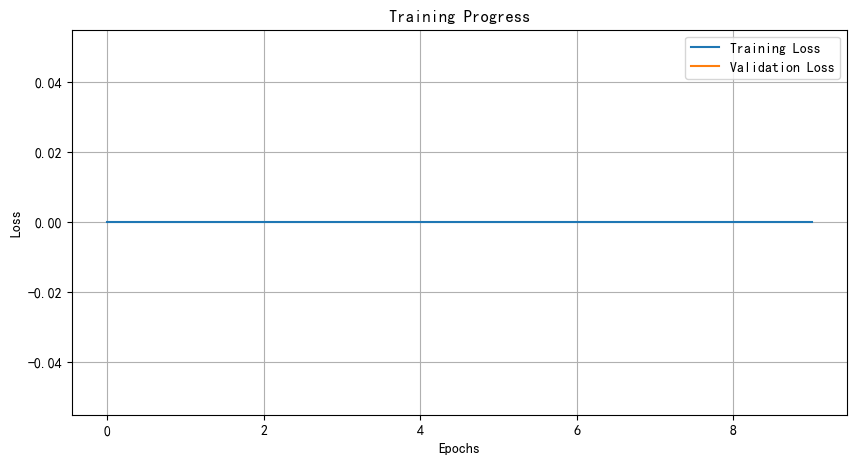

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(history['train'], label='Training Loss')
plt.plot(history['val'], label='Validation Loss')
plt.title('Training Progress')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

10.模型评估

In [11]:
from sklearn.metrics import mean_absolute_error
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号
def evaluate_detailed(model, data_loader, device, name=""):
    """
    详细评估模型性能，包括回归指标
    """
    model.eval()
    all_predictions = []
    all_targets = []
    total_loss = 0
    
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # 获取模型输出
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            
            # 收集预测结果
            all_predictions.extend(outputs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    # 转换为numpy数组
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    
    # 计算评估指标
    mae = mean_absolute_error(all_targets, all_predictions)
    mse = mean_squared_error(all_targets, all_predictions)
    rmse = np.sqrt(mse)
    corr = np.corrcoef(all_predictions, all_targets)[0, 1] if len(all_predictions) > 1 else 0
    
    # 计算方向准确率
    pred_direction = np.sign(all_predictions - np.mean(all_predictions))
    actual_direction = np.sign(all_targets - np.mean(all_targets))
    direction_accuracy = 100 * np.mean(pred_direction == actual_direction)
    
    # 打印结果
    print(f"\n{name}结果:")
    print(f"- 样本数量: {len(all_targets)}")
    print(f"- MAE: {mae:.4f}")
    print(f"- RMSE: {rmse:.4f}")
    print(f"- 相关系数: {corr:.4f}")
    print(f"- 方向准确率: {direction_accuracy:.2f}%")
    
    return all_predictions, all_targets, mae, corr, direction_accuracy, rmse

# 加载最佳模型并评估
try:
    # 加载检查点
    checkpoint = torch.load('best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    best_epoch = checkpoint['epoch']
    best_loss = checkpoint['loss']
    print(f"\n加载最佳模型 (epoch {best_epoch+1}, loss {best_loss:.4f})")
    
    # 评估训练集和验证集
    print("\n=== 最佳模型评估 ===")
    train_preds, train_acts, train_mae, train_corr, train_dir_acc, train_class_acc = evaluate_detailed(
    model, train_loader, device, "训练集")

    val_preds, val_acts, val_mae, val_corr, val_dir_acc, val_class_acc = evaluate_detailed(
    model, val_loader, device, "验证集")
    
    # 绘制预测结果
    plt.figure(figsize=(15, 5))
    
    # 训练集预测vs实际值
    plt.subplot(1, 2, 1)
    plt.scatter(train_acts, train_preds, alpha=0.5, label='预测点')
    plt.plot([train_acts.min(), train_acts.max()], 
             [train_acts.min(), train_acts.max()], 
             'r--', label='完美预测线')
    plt.title(f'训练集: 预测值 vs 实际值\nMAE: {train_mae:.4f}, 相关系数: {train_corr:.4f}')
    plt.xlabel('实际值')
    plt.ylabel('预测值')
    plt.legend()
    plt.grid(True)
    
    # 验证集预测vs实际值
    plt.subplot(1, 2, 2)
    plt.scatter(val_acts, val_preds, alpha=0.5, label='预测点')
    plt.plot([val_acts.min(), val_acts.max()], 
             [val_acts.min(), val_acts.max()], 
             'r--', label='完美预测线')
    plt.title(f'验证集: 预测值 vs 实际值\nMAE: {val_mae:.4f}, 相关系数: {val_corr:.4f}')
    plt.xlabel('实际值')
    plt.ylabel('预测值')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # 打印详细统计信息
    print("\n=== 详细统计信息 ===")
    print(f"训练集预测范围: [{train_preds.min():.4f}, {train_preds.max():.4f}]")
    print(f"训练集实际范围: [{train_acts.min():.4f}, {train_acts.max():.4f}]")
    print(f"验证集预测范围: [{val_preds.min():.4f}, {val_preds.max():.4f}]")
    print(f"验证集实际范围: [{val_acts.min():.4f}, {val_acts.max():.4f}]")
    
except Exception as e:
    print(f"评估过程中出错: {e}")
    print("\n调试信息:")
    for name, loader in [("训练集", train_loader), ("验证集", val_loader)]:
        total_samples = sum(len(targets) for inputs, targets in loader)
        print(f"{name}样本数: {total_samples}")

评估过程中出错: Error(s) in loading state_dict for ImprovedBiLSTMAttention:
	Missing key(s) in state_dict: "regressor.0.weight", "regressor.0.bias", "regressor.2.weight", "regressor.2.bias", "regressor.2.running_mean", "regressor.2.running_var", "regressor.4.weight", "regressor.4.bias". 
	Unexpected key(s) in state_dict: "classifier.0.weight", "classifier.0.bias", "classifier.2.weight", "classifier.2.bias", "classifier.2.running_mean", "classifier.2.running_var", "classifier.2.num_batches_tracked", "classifier.4.weight", "classifier.4.bias". 

调试信息:
训练集样本数: 24768
验证集样本数: 6144


11.结果可视化

NameError: name 'train_acts' is not defined

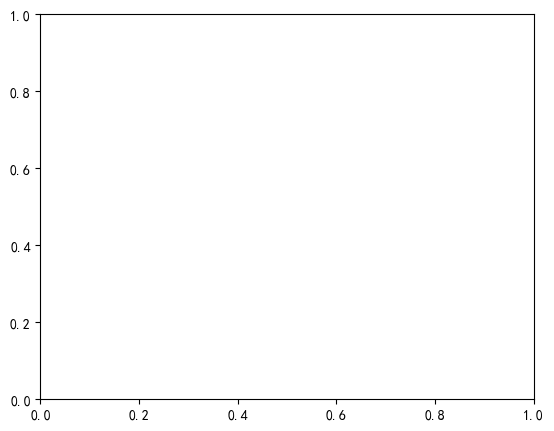

In [12]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.scatter(train_acts, train_preds, alpha=0.3)
plt.title('训练集预测 vs 实际')
plt.xlabel('实际值')
plt.ylabel('预测值')

plt.subplot(1, 2, 2)
plt.scatter(val_acts, val_preds, alpha=0.3, color='orange')
plt.title('验证集预测 vs 实际')
plt.xlabel('实际值')

plt.tight_layout()
plt.show()

12.模型保存

In [19]:
torch.save({
    'model_state': model.state_dict(),
    'input_dim': windows[0].shape[-1],
    'scaler': scaler
}, 'crypto_predictor.pth')

print("模型已保存为 crypto_predictor.pth")

模型已保存为 crypto_predictor.pth
